In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sns.set()

save = False

In [2]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

from continual_gp.datasets import ToyDataset
from continual_gp.train_utils_global import create_class_gp
from continual_gp.train_utils import set_seeds

/Users/thang.bui/miniconda3/envs/cgp/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


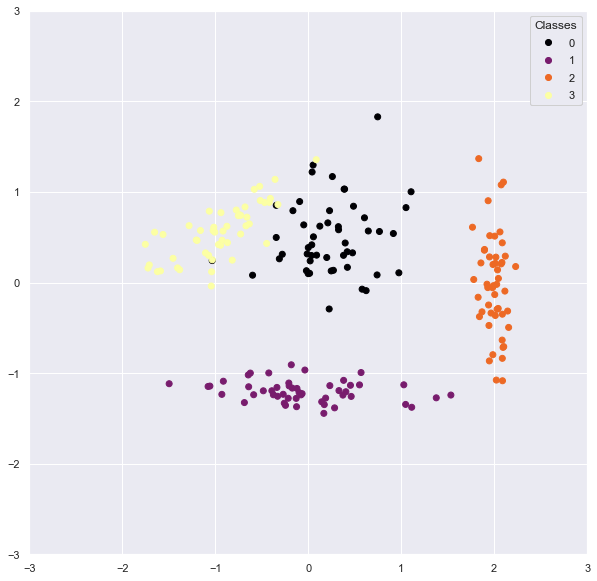

In [3]:
set_seeds(1)

toy_ds = ToyDataset()

fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(toy_ds.data[:, 0], toy_ds.data[:, 1], c=toy_ds.targets, cmap=plt.get_cmap('inferno'), label=toy_ds.targets)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
legend = ax.legend(*scatter.legend_elements(), loc="top right", title="Classes")
ax.add_artist(legend)
if save:
    fig.savefig('/tmp/toy_data.png', bbox_inches='tight', pad_inches=0)

In [4]:
grid_data = torch.cat([v.unsqueeze(-1) for v in torch.meshgrid([torch.arange(-3,3,0.1), torch.arange(-3,3,0.1)])], dim=-1).permute(1, 0, 2)

def plot_classes(preds, z=None):
    out = preds.reshape(*grid_data.shape[:-1], -1)

    fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(30,10))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    cim = None
    for i in range(preds.size(-1)):
        cim = axes[i].imshow(out[..., i], interpolation='gaussian', cmap='viridis', extent=(-3,3,-3,3), origin='lower')
        # cim = axes[i].scatter(grid_data[..., 0], grid_data[..., 1], c=out[..., i], cmap='viridis')
        axes[i].set(aspect='equal')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)
        axes[i].grid(False)

        if z is not None:
            axes[i].scatter(z[i, ..., 0], z[i, ..., 1], marker='o', facecolor='white', edgecolor='black')

    # fig.colorbar(cim, ax=axes.ravel().tolist(), shrink=0.5)

    return fig, axes

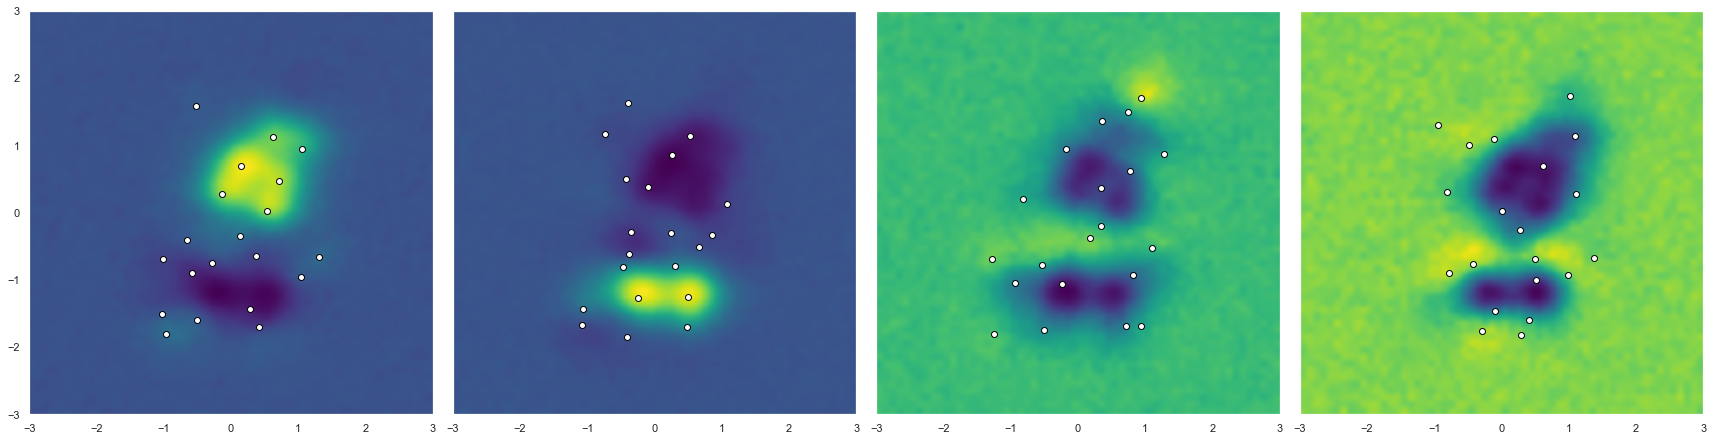

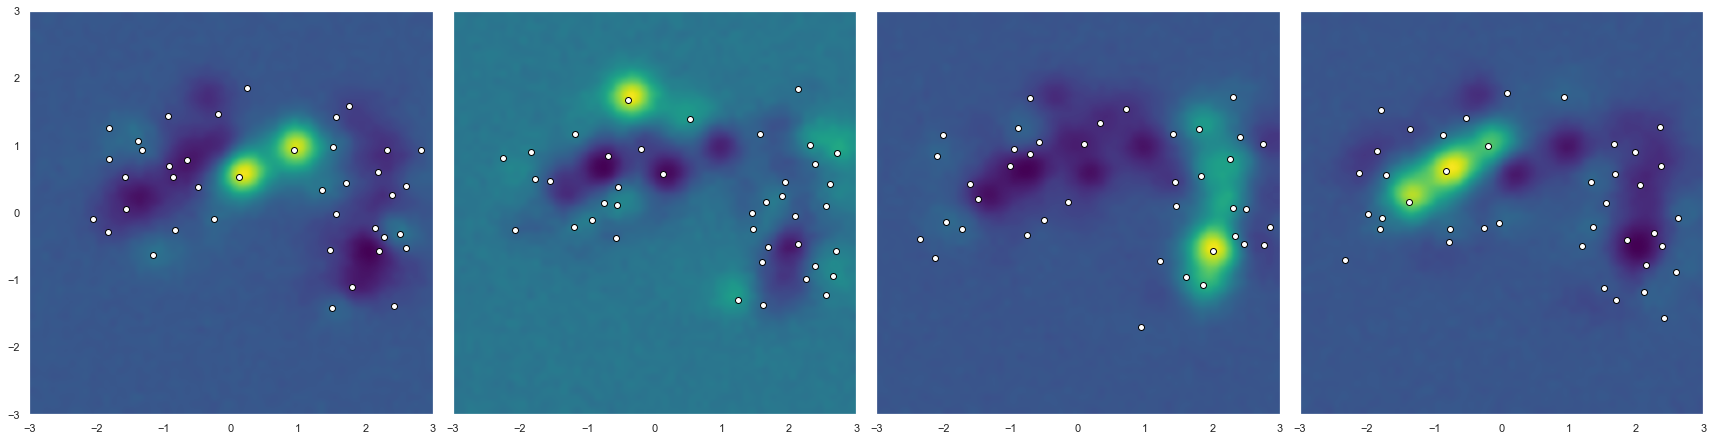

In [14]:
import numpy as np
run_dir = "../experiments/wandb/dryrun-20200404_153451-1h20kg09"

prev_params = []
M = 20
for t in range(2):
    toy_ds.filter_by_class(range(2 * t + 2))

    with torch.no_grad():
        cur_params = torch.load(f'{run_dir}/ckpt{t}.pt')
        gp = create_class_gp(toy_ds, M=M*(t+1), n_f=50, n_var_samples=20, prev_params=prev_params).to(device)
        gp.load_state_dict(cur_params)

        fig, _ = plot_classes(gp.predict(grid_data.reshape(-1, 2)), z=cur_params.get('z'))
        if save:
            fig.savefig(f'/tmp/toy_var_gp_{t + 1}.png', bbox_inches='tight', pad_inches=0)

    prev_params = [cur_params]